### UNIVERSIDAD POLITECNICA SALESIANA
#### Alumno: Juan Cañar.
#### Docente: Ing. Diego Quisi

# Covid-19 infección en Ecuador. Modelos probabilisticos
Implementacion de un modelo probabilistico de infección por el virus Covid-19

Se realiza un análisis probabilistico simple del crecimiento de la infección en Python y el modelos para comprender mejor la evolución de la infección.

Se crea modelos de series temporales del número total de personas infectadas hasta la fecha (es decir, las personas realmente infectadas más las personas que han sido infectadas). Estos modelos tienen parámetros , que se estimarán por ajuste de probabilidad.

In [1]:
# Importar las librerias para el analasis
import pandas as pd
import numpy as np
from scipy.integrate import solve_ivp
from scipy.optimize import minimize
from scipy.integrate import odeint
from datetime import datetime,timedelta
from sklearn.metrics import mean_squared_error
from scipy.optimize import curve_fit
from scipy.optimize import fsolve
from sklearn import linear_model
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# Actualizar los datos (URL)
url = 'https://covid.ourworldindata.org/data/ecdc/new_cases.csv'
df = pd.read_csv(url)
df

,date,World,Afghanistan,Albania,Algeria,Andorra,Angola,Anguilla,Antigua and Barbuda,Argentina,...,Uzbekistan,Vanuatu,Vatican,Venezuela,Vietnam,Wallis and Futuna,Western Sahara,Yemen,Zambia,Zimbabwe
0,2019-12-31,27,0.0,NaN,0.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN
1,2020-01-01,0,0.0,NaN,0.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN
2,2020-01-02,0,0.0,NaN,0.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN
3,2020-01-03,17,0.0,NaN,0.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN
4,2020-01-04,0,0.0,NaN,0.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
319,2020-11-14,634423,66.0,490.0,867.0,109.0,104.0,0.0,2.0,11859.0,...,63.0,0.0,0.0,0.0,3.0,0.0,0.0,2.0,57.0,69.0
320,2020-11-15,597736,205.0,532.0,844.0,0.0,171.0,0.0,1.0,8468.0,...,0.0,0.0,0.0,301.0,9.0,0.0,0.0,0.0,4.0,21.0
321,2020-11-16,504453,163.0,597.0,860.0,147.0,146.0,0.0,0.0,5645.0,...,563.0,0.0,0.0,911.0,16.0,0.0,0.0,0.0,26.0,0.0
322,2020-11-17,554913,65.0,602.0,910.0,42.0,77.0,0.0,0.0,7895.0,...,201.0,0.0,0.0,387.0,2.0,0.0,0.0,0.0,64.0,111.0


Imprimos los resultados y agregamos el numero del dia


In [3]:
df = df.loc[:,['date','Ecuador']] #Selecciono las columnas de analasis
# Expresar las fechas en numero de dias desde el 01 Enero
FMT = '%Y-%m-%d'
date = df['date']
df['date'] = date.map(lambda x : (datetime.strptime(x, FMT) - datetime.strptime("2020-01-01", FMT)).days)
df

,date,Ecuador
0,-1,0.0
1,0,0.0
2,1,0.0
3,2,0.0
4,3,0.0
...,...,...
319,318,1161.0
320,319,953.0
321,320,668.0
322,321,381.0


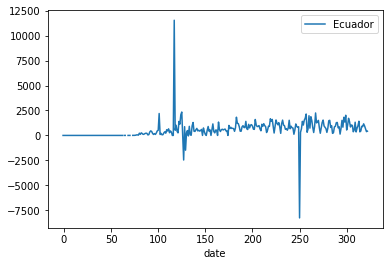

In [4]:
df.plot(x ='date', y='Ecuador')

Ahora podemos analizar un modelo probabilisto para el examen.

## El modelo basado en probabilidad

Para realizar un estimacion del factor de crecimiento de los casos de Covid 19 en Ecuador calculamos la mediana, con esto obtenemo el valor medio de crecimiento de un conjunto de datos, con esto podemos obtener un factor de crecimiento o taza de crecimiento de los nuevos casos.



In [6]:
filtro = df["Ecuador"][61:] # Filtro los datos que se empezo a tener casos
#Obtenemos la mediana
media = filtro.mean()
mediana = filtro.median()
print('MEDIANA : -->',mediana)
print('MEDIA : -->',media)

MEDIANA : --> 663.0
MEDIA : --> 701.953488372093


De la ecuación de la recta y = mX + b nuestra pendiente «m» es el coeficiente y el término independiente «b»


In [45]:
#Vamos a comprobar:
# según la media y la mediana podemos obtener la taza de crecieminto y predicir su comportamiento.
# Cargamos los datos de total de casos
url = 'https://covid.ourworldindata.org/data/ecdc/total_cases.csv'
df_t = pd.read_csv(url)
df_t = df_t.replace(np.nan, 0)
FMT = '%Y-%m-%d'
date = df_t['date']
df_t['date'] = date.map(lambda x : (datetime.strptime(x, FMT) - datetime.strptime("2020-01-01", FMT)).days)
df_t = df_t.loc[:,['date','Ecuador']] #Selecciono las columnas de analasis
#df_t = df_t[df_t['date'] > 59]
#df_t['Ecuador'] = df['Ecuador'].fillna(0)
y = list(df_t.iloc [:, 1]) # Total casos
x = list(df_t.iloc [:, 0]) # Dias
#Realizamos un ejemplo de prediccion
prediccion_siguiente = int(y[-1] + mediana)
print(prediccion_siguiente)

181767


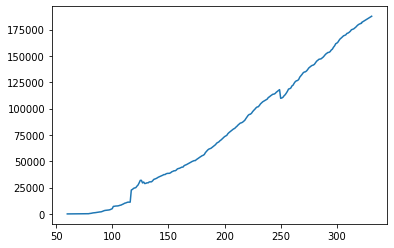

In [46]:
# Quiero predecir cuántos "Casos" voy a obtener de aqui a 10 dias.
for i in range(x[-1], x[-1]+10):
    x.append(i)
    y.append(int(y[-1] + mediana))
plt.plot(x[61:], y[61:])
plt.show()

# Practica - DEBER 

1. Comparar el modelo de predicion matematico vs probabilidad.
2. Generar el SIR en base al modelo de probabilidad y obtener beta y gamma con una semana de prediccion.
3. Retroceder un semana y comparar el modelo matematico vs probabilidad vs reales. Solo cargan los datos para generar los modelos menos 7 dias.

Puntos extras: Investigas sobre la correlacion de variables y aplicar el calculo en base a los datos del Ecuador.

**1. Comparar el modelo de predicion matematico vs probabilidad.**

---
#### Modelo probabilístico

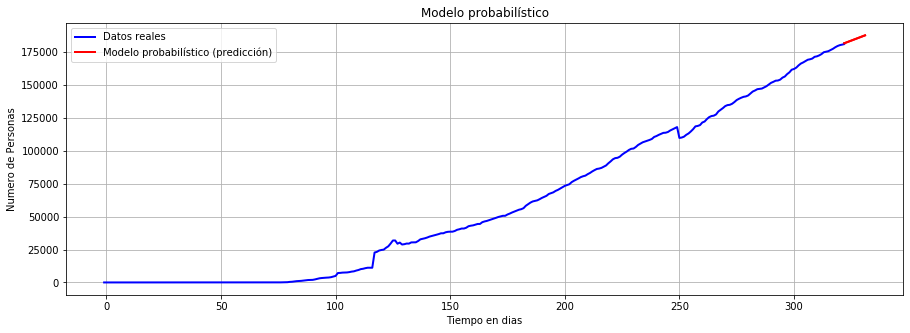

In [47]:
# Implementar
#                             1. Comparar el modelo de predicción matemático vs probabilístico:
# Modelo probabilístico
fig = plt.figure(figsize=(15,5))
ax = fig.add_subplot(111, axisbelow=True)
ax.plot(x[:len(x)-9], y[:len(x)-9],'b', alpha=1, lw = 2, label = 'Datos reales')
ax.plot(x[len(x)-10:], y[len(x)-10:],'r', alpha=1, lw = 2, label = 'Modelo probabilístico (predicción)')
ax.set_xlabel('Tiempo en dias')
ax.set_ylabel('Numero de Personas')
ax.set_title("Modelo probabilístico")
ax.legend()
ax.grid()
x_matematico = x[:]
y_matematico = y[:]
ax.plot(x[len(x)-10:], y[len(x)-10:],'r', alpha=1, lw = 2, label = 'Modelo probabilístico (predicción)')

In [48]:
prediccion_siguiente = int(y[-1] + mediana)
print('________________________________________________')
print('---------MODELO PROBABILISTICO---------')
print('TOTAL DE CASOS + MEDIANA: ',prediccion_siguiente)
print('TOT, FECHA ACTUAL: ',y[321])
for i in range(x[-1], x[-1]+7):
    x.append(i)
    y.append(int(y[-1] + mediana))
print('________________________________________________')
print('SE ESTIMA PARA LA SEMANA SIGUIENTE:',y[-1]+7, 'CONTAGIOS ')#Se suma 7 dias

________________________________________________
---------MODELO PROBABILISTICO---------
TOTAL DE CASOS + MEDIANA:  188397
TOT, FECHA ACTUAL:  180295.0
________________________________________________
SE ESTIMA PARA LA SEMANA SIGUIENTE: 192382 CONTAGIOS 


---
#### Modelo polinomial

______________________________________________________________
RESULTADOS: 
Dato actual: 91922 contagiados


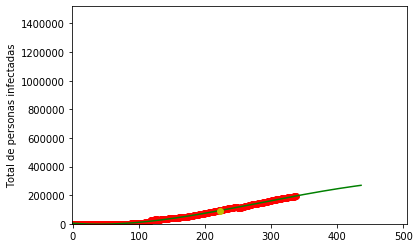

In [71]:
#Implementar
from sklearn.linear_model import LinearRegression 
from sklearn.preprocessing import PolynomialFeatures 
pf = PolynomialFeatures(degree = 4)    
X = pf.fit_transform(np.array(x).reshape(-1, 1))

regresion_lineal = LinearRegression()

regresion_lineal.fit(X, y) 
pred_x = list(range(0,max(x)+100))

puntos = pf.fit_transform(np.array(pred_x).reshape(-1, 1))
prediccion_entrenamiento = regresion_lineal.predict(puntos)
print('______________________________________________________________')
print('RESULTADOS: ')
print ('Dato actual:', int(prediccion_entrenamiento[222]), 'contagiados')
#print( x)

plt.plot(pred_x, prediccion_entrenamiento, color='green')
plt.scatter(x,y,label="Datos Reales",color="red")
plt.ylim((-300,max(y)*7.9))
plt.xlim((min(x)*0.9,max(x)*1.5))
plt.ylabel("Total de personas infectadas")
plt.plot(222,prediccion_entrenamiento[222], 'oy')
plt.show()

**3.Retroceder un semana y comparar el modelo matematico vs probabilidad vs reales. Solo cargan los datos para generar los modelos menos 7 dias.**

---
#### DESARROLLO: 

___________________________________________
Media una semana antes: 857.3947368421053
___________________________________________
Mediana una semana antes: 868.5
___________________________________________
Predicion una semana antes:  176579
PREDICCION 0  X DIA 1 --> 176579 CASOS POSIBLES
PREDICCION 1  X DIA 2 --> 177448 CASOS POSIBLES
PREDICCION 2  X DIA 3 --> 178316 CASOS POSIBLES
PREDICCION 3  X DIA 4 --> 179184 CASOS POSIBLES
PREDICCION 4  X DIA 5 --> 180053 CASOS POSIBLES
PREDICCION 5  X DIA 6 --> 180922 CASOS POSIBLES
PREDICCION 6  X DIA 7 --> 181790 CASOS POSIBLES


<function matplotlib.pyplot.show(*args, **kw)>

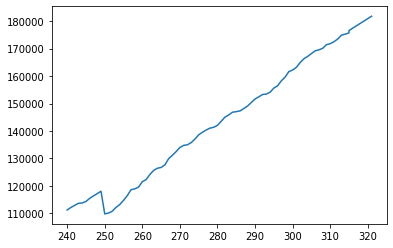

In [96]:
TotalSemanaPasada=df['Ecuador'][241:len(df)-7]
y_semanantes = list(df_t.iloc [:, 1]) # Total casos
x_semanantes = list(df_t.iloc [:, 0]) # Dias
for i in range (7):
    y_semanantes.pop(-1)
    x_semanantes.pop(-1)
#Mediana
media_semanantes=TotalSemanaPasada.mean()
print('___________________________________________')
print('Media una semana antes:', media_semanantes)
mediana_semanantes=SemanaAntes.median()
print('___________________________________________')
print('Mediana una semana antes:', mediana_semanantes)

#Realizamos un ejemplo de prediccion
prediccion_semana_antes = int(y_semanantes[-1] + mediana_semanantes)
print('___________________________________________')
print('Predicion una semana antes: ',prediccion_semana_antes)

for i in range(x_semanantes[-1], x_semanantes[-1]+7):
    x_semanantes.append(i)
    y_semanantes.append(int(y_semanantes[-1]+mediana_semanantes))
    
for i in range(7):
    print('PREDICCION',i,' X DIA',i+1,'-->',round(prediccion_semana_antes),'CASOS POSIBLES')
    prediccion_semana_antes=prediccion_semana_antes+mediana_semanantes
    
plt.plot(x_semanantes[241:], y_semanantes[241:])
plt.show

___________________________________________
RESULTADO:
Predicción una semana antes: 13712.0 contagiados


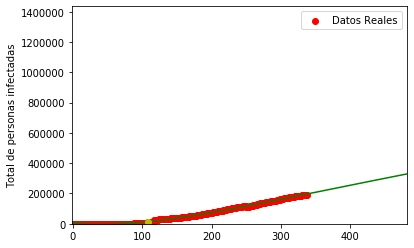

In [103]:
from sklearn.linear_model import LinearRegression 
from sklearn.preprocessing import PolynomialFeatures 

pf = PolynomialFeatures(degree = 4)    # usaremos polinomios de grado 6
X = pf.fit_transform(np.array(x_semanantes).reshape(-1, 1))

regresion_lineal = LinearRegression()
regresion_lineal.fit(X,y_semanantes ) 

pred_x = list(range(0,max(x_semanantes)+200))
puntos = pf.fit_transform(np.array(pred_x).reshape(-1, 1))
prediccion_entrenamiento = regresion_lineal.predict(puntos)
print('___________________________________________')
print('RESULTADO:')
print ('Predicción una semana antes:', round(prediccion_entrenamiento[108]), 'contagiados')
plt.plot(pred_x, prediccion_entrenamiento, color='green')
plt.scatter(x,y,label="Datos Reales",color="red")
plt.ylim((-300,max(y_semanantes)*7.9))
plt.xlim((min(x_semanantes)*0.9,max(x_semanantes)*1.5))
plt.ylabel("Total de personas infectadas")
plt.plot(108,prediccion_entrenamiento[108], 'oy')
plt.legend()
plt.show()

----

## Analisis
Modelo probabilístico o estadístico, describen un conjunto de distribuciones de probabilidad, que son capaces de aproximar de manera adecuada un conjunto de datos, incorporando nuevos predictores elevando el valor de los casos ya existentes a diferentes potencias, por lo que un polinomio de cuarto grado podría capturar mejor la relación entre las variables. 

## Conclusiones
Como conclusion se puede decir que estos modelos matematicos son herramientas que nos ayudan a simular o predecir en un futuro los eventos que pasaran, aunque cabe recalcar que estos modelos son bastante subjetivos, lo que podria no acertar en su totalidad los eventos, pero si nos podria dar una referencia intermedia para poder tener un concepto claro, de como va ha afectarnos o que probabilidades existen de incremento o decremento.

## Criterio personal (politico, economico y  social de la situacion)

El ambito politico frente al covid juega un papel muy importante, ya que un buen manejo de los recursos del pais, puede dar una pronta respuesta a la pandemia mediante un buen manejo de entidades de salud y una buena planificacion, esto de cierta forma ayudaria a reducir los contagios y a manejar de mejor manera, ya que en pleno rebrote fuimos uno de los paises latinoamericanos mas afectado y con un alto indice de mortalidad como consecuencia del mal manejo y de la descarada corrupcion que existe, en cuanto a lo economico, es una etapa bastante dificil para el pais y su comunidad, debido a que la tasa de subempleo incrementa y tambien existen reduccion en la nomida de empleados, lo que trae consigo como consecuencia, que las personas no tengan dinero para mantenerse, tampoco puden acceder a la canasta basica, que desencadena en varios factores tales como desnutricion, enfermedades, personas sin hogar por la falta de posibilidades economicas, otros buscan obtener ingresos mediante microemprendimientos, para aliviar de cierta forma este problema, y en lo social haciendo referencia a puntos mencionados anteriormente se puede decir que afecta a todas las personas, en distintos ambitos tales como empleo, ingresos, comercios, salud, vivieda.

# Referencias

- https://www.researchgate.net/publication/340092755_Infeccion_del_Covid-19_en_Colombia_Una_comparacion_de_modelos_logisticos_y_exponenciales_aplicados_a_la_infeccion_por_el_virus_en_Colombia

- https://www.aprendemachinelearning.com/regresion-lineal-en-espanol-con-python/
- https://www.ccg.unam.mx/~vinuesa/R4biosciences/docs/Tema9_regresion.html